In [1]:
%load_ext autoreload

%autoreload 2

In [12]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import osmnx as ox
from typing import List, Tuple, Dict, Any, Optional
from networkx import Graph
from metroscore.network_builder import *
from shapely.geometry import Point, LineString
from random import random, choice

%config InlineBackend.figure_format = 'retina'

In [3]:
PLACE = "Beacon, NY, USA"

# Importing Drive-Time networks

In this section, we will import a road network for a given place, clean it,
and ensure we have an attribute for all edges called "drive" which indicates the number
of seconds it will take to traverse that section of road.

In [32]:
G = ox.graph_from_place(
    PLACE, 
    retain_all=False, 
    truncate_by_edge=True, 
    simplify=True, 
    network_type='drive'
)
G = ox.project_graph(G)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [33]:
def get_random_edge(G: Graph) -> Tuple[int, int, Dict[str, Any]]:
    edge = choice(list(G.edges(data=True)))
    return edge

In [34]:
e = get_random_edge(G)
e

(261859370,
 261878075,
 {'osmid': 142433203,
  'name': 'East Main Street',
  'highway': 'residential',
  'oneway': False,
  'reversed': False,
  'length': 149.345,
  'geometry': <LINESTRING (586724.01 4594909.461, 586756.024 4594857.325, 586791.413 45948...>,
  'speed_kph': 59.3,
  'travel_time': 9.1})

In [35]:
def highlight_edge_in_graph(G: Graph, a: int, b: int):
    fig, ax = ox.plot_graph(G, show=False, close=False, edge_linewidth=0.5, node_size=0.8)
    ox.plot_graph_route(G, [a, b], route_linewidth=1.5, route_color='r', ax=ax)
    plt.show()

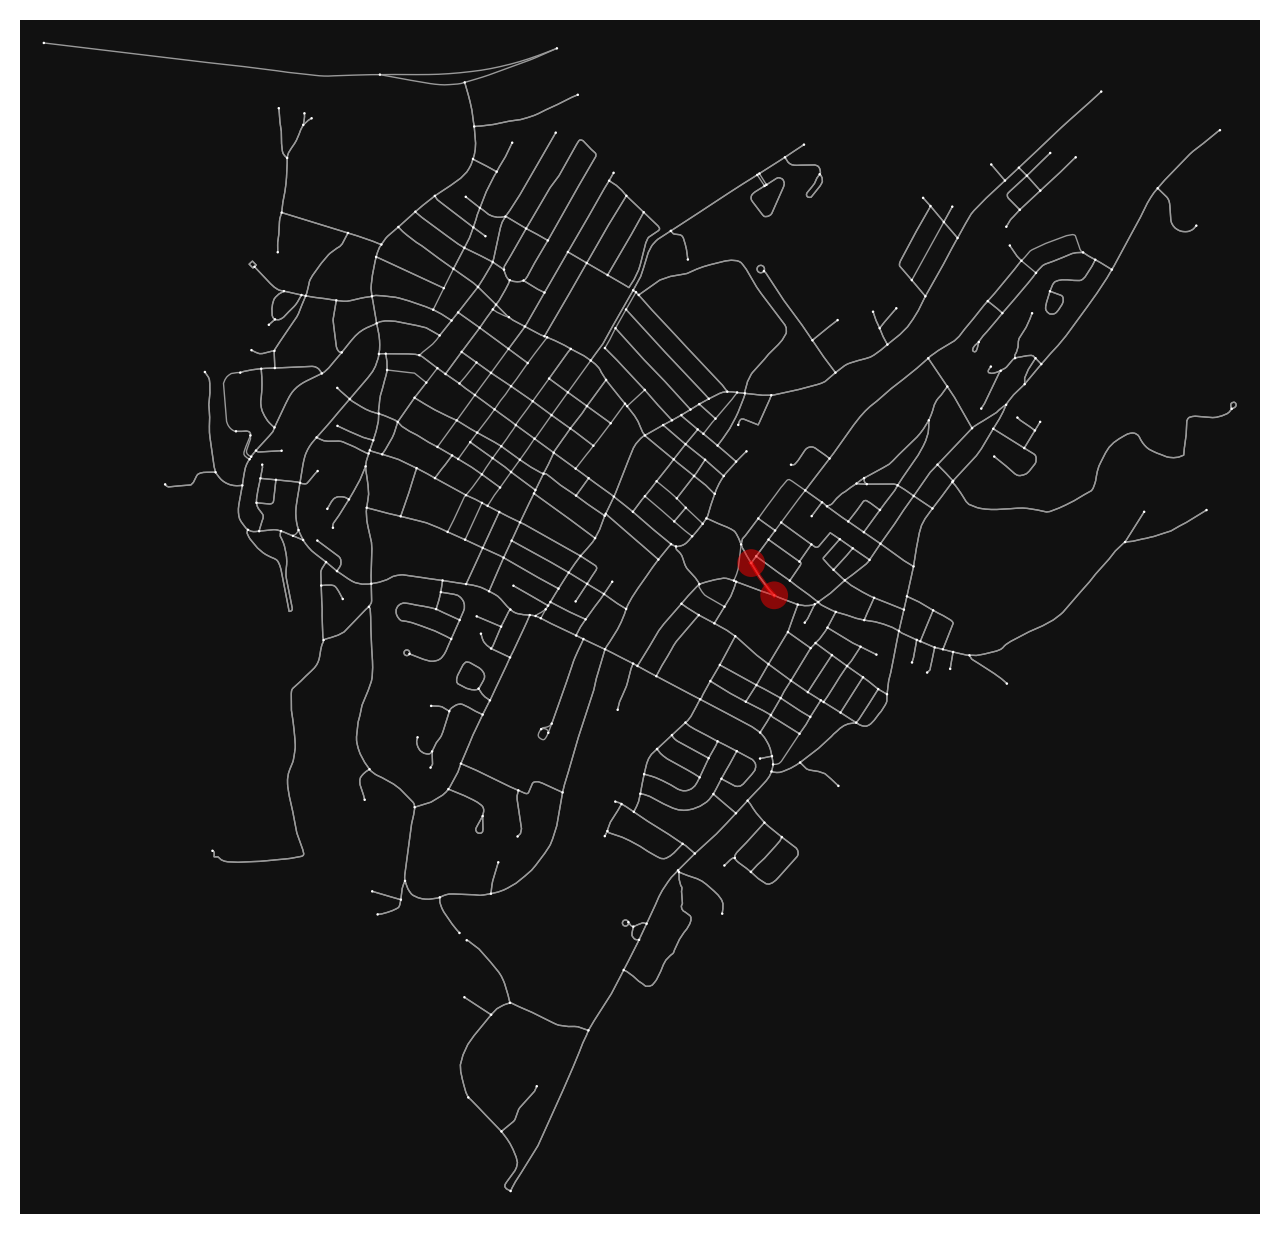

In [36]:
highlight_edge_in_graph(G, e[0], e[1])

In [38]:
# TODO: rename travel time to 'drive'

# Importing Rail Networks

This time, we'll import a rail network and use GTFS to append travel times for each edge.

Idea: use average wait time and add that to the edge's travel time in lieu of specific headways given departure time

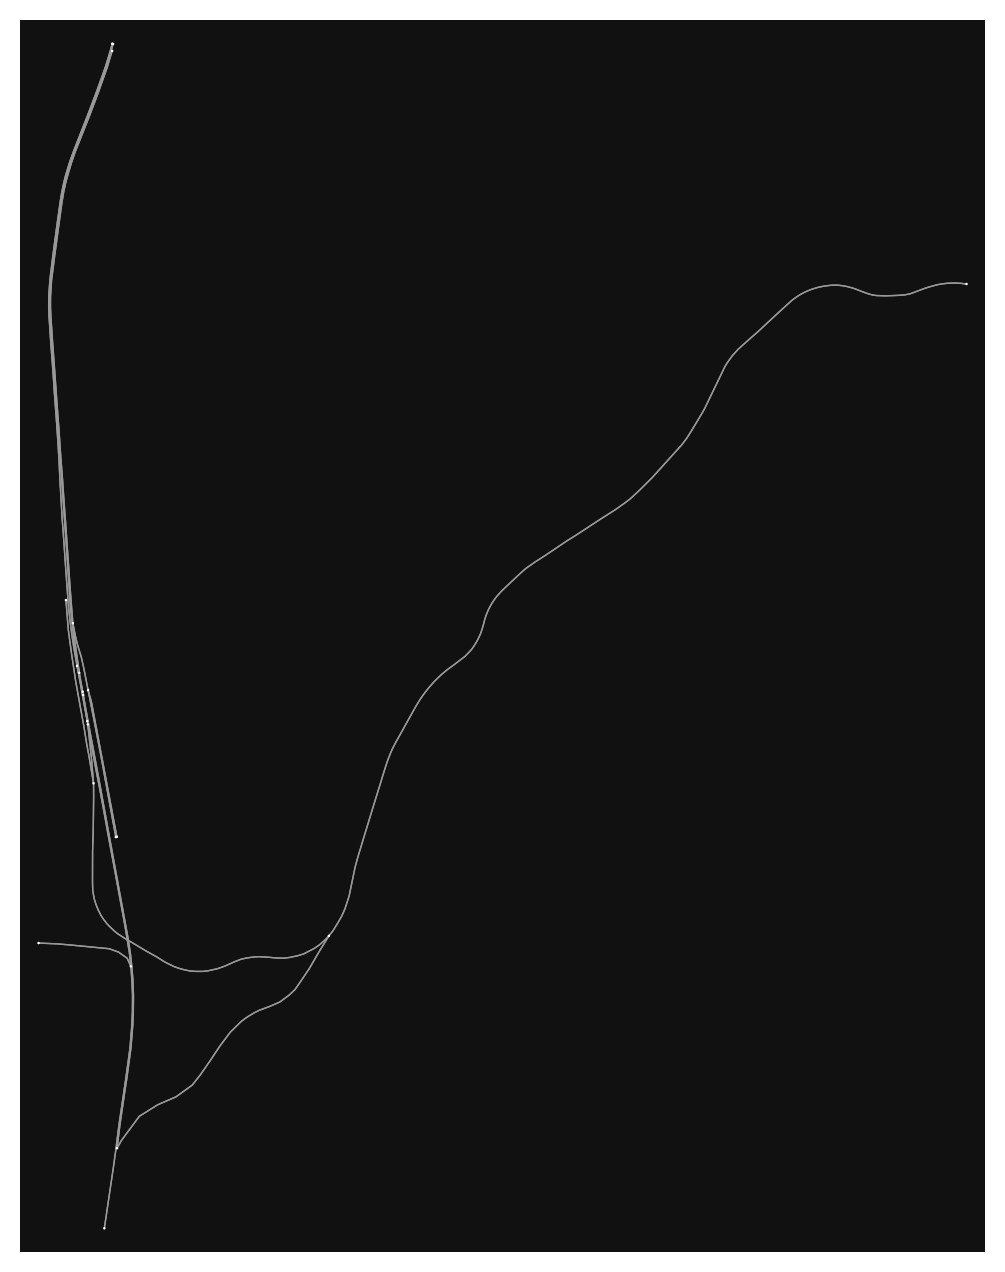

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [37]:
R = ox.graph_from_place(
    PLACE, 
    retain_all=False, 
    truncate_by_edge=True, 
    simplify=True, 
    custom_filter='["railway"]'
)

ox.plot_graph(R, node_size=0.8, edge_linewidth=0.5)

# Importing Bus Networks

Similar to rail networks, we'll create a network of bus routes. To do this, we'll start
with the road network, then append a GTFS source to truncate the roads down to those traversed by buses.
Finally, we'll append travel times to the edges with the key 'bus'.

# Importing Bike Networks

This one's pretty simple. We just call OSMNx for it since it supports it out of the box.

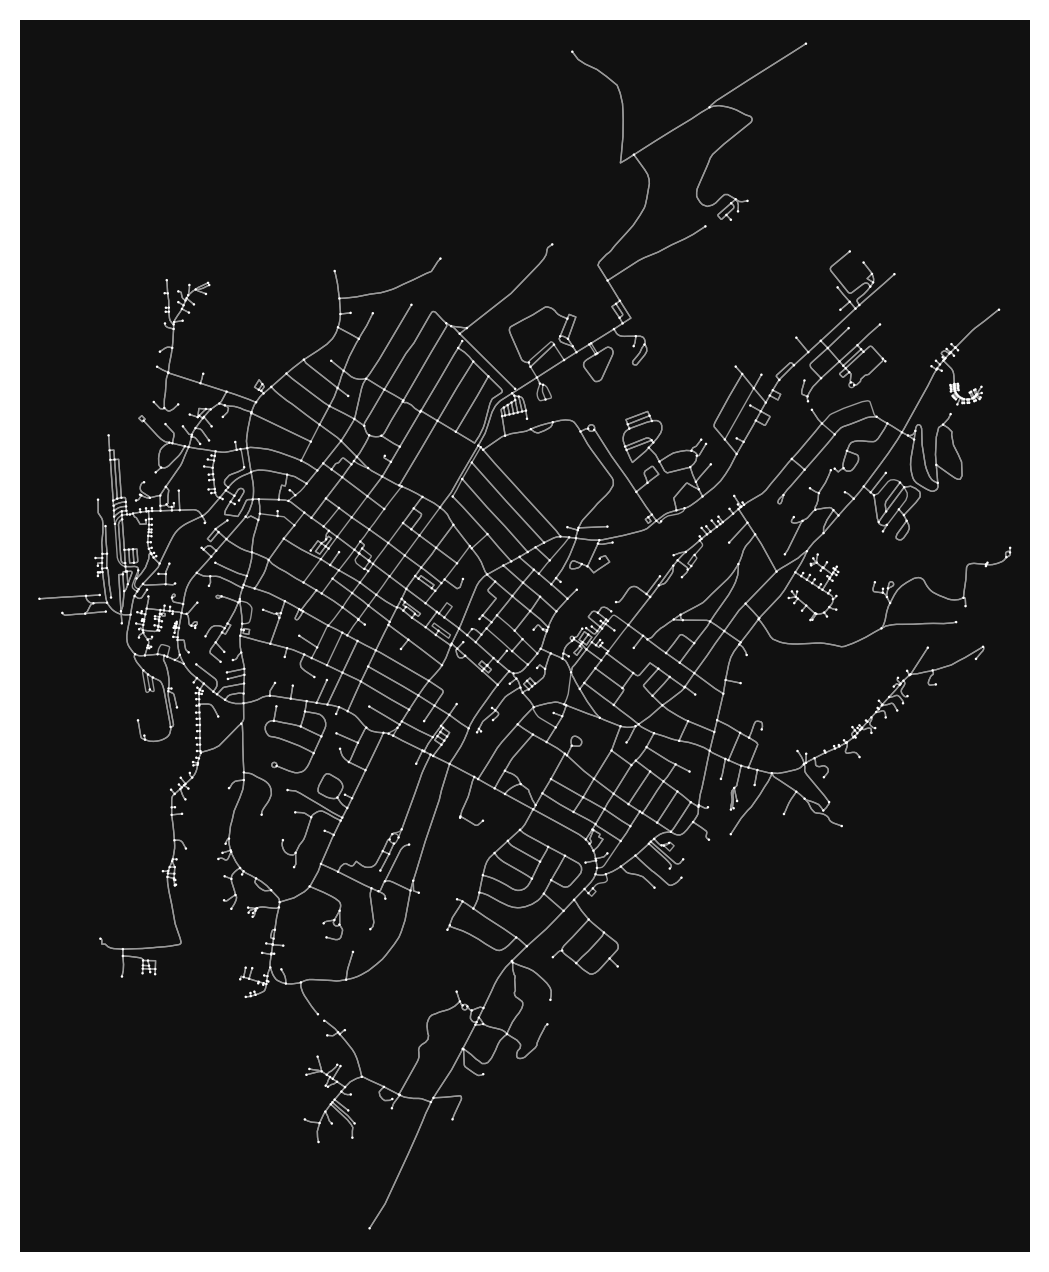

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [40]:
B = ox.graph_from_place(
    PLACE, 
    retain_all=False, 
    truncate_by_edge=True, 
    simplify=True, 
    network_type='bike'
)

ox.plot_graph(B, node_size=0.8, edge_linewidth=0.5)